# Recommendation Model

We are developing the recommendation for anime watcher by using dataset from MyAnimeList.net

Reference:


*   https://www.youtube.com/watch?v=G4MBc40rQ2k&t=302s
*   https://github.com/SpencerPao/Data_Science/tree/main/Recommendation%20Systems


Dataset:


*   https://www.kaggle.com/datasets/svanoo/myanimelist-dataset



## Import Dataset

In [ ]:
# the necessary library for recommendation

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader 
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
import os

In [ ]:
# Check if GPU is available

print("PyTorch version: {}\n".format(torch.__version__))

# Check PyTorch has access to GPU
print("Is GPU available? {}\n".format(torch.cuda.is_available()))

# Set the device      
device = "gpu" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(device))

PyTorch version: 1.11.0+cu113

Is GPU available? True

Using device: gpu


In [ ]:
# access google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Model Recommendation/dataset'
CHECKPOINT_PATH = '/content/drive/MyDrive/Model Recommendation/checkpoints'
MODEL_PATH = '/content/drive/MyDrive/Model Recommendation'
# PATH = ''
# DATA_PATH = ''
# MODEL_PATH = ''

# import dataset
df_animes = pd.read_csv(DATA_PATH + '/anime.csv')
print("\nDownload Anime Files - completed\n")


df_users = pd.read_csv(DATA_PATH + '/user.csv')
print("\nDownload User Files - completed\n")

df_ratings = None
df_ratings_01 = pd.read_csv(DATA_PATH + '/user_anime/user_anime01.csv')


Download Anime Files - completed


Download User Files - completed



## Data Visualization

In [ ]:
df_animes.head()

,anime_id,anime_url,title,synopsis,main_pic,type,source_type,num_episodes,status,start_date,...,score_08_count,score_07_count,score_06_count,score_05_count,score_04_count,score_03_count,score_02_count,score_01_count,clubs,pics
0,2366,https://myanimelist.net/anime/2366/Touma_Kishi...,Touma Kishinden Oni,Shuramaru is hated and feared by the villagers...,https://cdn.myanimelist.net/images/anime/9/829...,TV,Game,25.0,Finished Airing,5/10/1995 00:00,...,0,0,0,0,0,0,0,0,14045|10778|342,https://cdn.myanimelist.net/images/anime/9/544...
1,4940,https://myanimelist.net/anime/4940/Sabaku_no_K...,Sabaku no Kaizoku! Captain Kuppa,"Sometime in the future, the world was complete...",https://cdn.myanimelist.net/images/anime/9/736...,TV,Manga,26.0,Finished Airing,13/8/2001 00:00,...,0,0,0,0,0,0,0,0,8494,https://cdn.myanimelist.net/images/anime/9/736...
2,50285,https://myanimelist.net/anime/50285/On_Air_Dek...,On Air Dekinai!,"Set in 2014, the anime follows the adventures ...",https://cdn.myanimelist.net/images/anime/1021/...,TV,Manga,12.0,Currently Airing,10/1/2022 00:00,...,0,0,0,0,0,0,0,0,27907|8652,https://cdn.myanimelist.net/images/anime/1021/...
3,3975,https://myanimelist.net/anime/3975/Uchi_no_3_S...,Uchi no 3 Shimai,The daily life of the Motsumoto family. The th...,https://cdn.myanimelist.net/images/anime/1631/...,TV,Other,102.0,Finished Airing,8/4/2008 00:00,...,0,0,0,0,0,0,0,0,69895,https://cdn.myanimelist.net/images/anime/3/716...
4,36036,https://myanimelist.net/anime/36036/Running_Man,Running Man,"The Soul Tree, the great source of our race. ...",https://cdn.myanimelist.net/images/anime/1325/...,TV,Other,48.0,Finished Airing,29/7/2017 00:00,...,0,0,0,0,0,0,0,0,41909,https://cdn.myanimelist.net/images/anime/1325/...


In [ ]:
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13379 entries, 0 to 13378
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anime_id             13379 non-null  int64  
 1   anime_url            13379 non-null  object 
 2   title                13379 non-null  object 
 3   synopsis             13375 non-null  object 
 4   main_pic             13379 non-null  object 
 5   type                 13379 non-null  object 
 6   source_type          13379 non-null  object 
 7   num_episodes         12948 non-null  float64
 8   status               13379 non-null  object 
 9   start_date           13198 non-null  object 
 10  end_date             12799 non-null  object 
 11  season               4280 non-null   object 
 12  studios              10343 non-null  object 
 13  genres               13379 non-null  object 
 14  score                10714 non-null  float64
 15  score_count          10714 non-null 

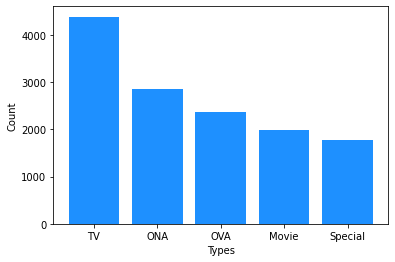

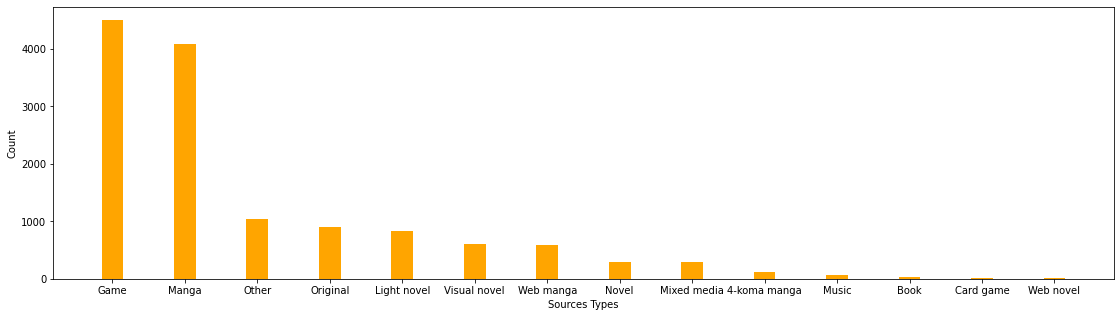

In [ ]:
# Count number of types
types = df_animes['type'].unique()
n_types = df_animes['type'].value_counts()
plt.bar(types, n_types, color ='dodgerblue')
plt.xlabel("Types")
plt.ylabel("Count")
plt.show()

# Count number of source types
sources = df_animes['source_type'].unique()
n_sources = df_animes['source_type'].value_counts()
fig = plt.figure(figsize = (19, 5))
plt.bar(sources, n_sources, color ='orange', width = 0.3)
plt.xlabel("Sources Types")
plt.ylabel("Count")
plt.show()

In [ ]:
df = df_animes[['anime_id', 'title', 'genres', 'score_rank']]
df.sort_values(by=['score_rank'], ascending=True).head(10)

,anime_id,title,genres,score_rank
4334,5114,Fullmetal Alchemist: Brotherhood,Action|Adventure|Comedy|Drama|Fantasy|Military...,1.0
4108,28977,Gintama¬∞,Action|Comedy|Sci-Fi|Historical|Parody|Samurai...,2.0
2349,9253,Steins;Gate,Drama|Sci-Fi|Suspense|Psychological,3.0
2037,38524,Shingeki no Kyojin Season 3 Part 2,Action|Drama|Fantasy|Mystery|Military|Super Po...,4.0
3456,48583,Shingeki no Kyojin: The Final Season Part 2,Action|Drama|Fantasy|Mystery|Military|Super Po...,5.0
4330,9969,Gintama',Action|Comedy|Sci-Fi|Historical|Parody|Samurai...,6.0
10341,39486,Gintama: The Final,Action|Comedy|Drama|Sci-Fi|Historical|Parody|S...,7.0
2659,11061,Hunter x Hunter (2011),Action|Adventure|Fantasy|Super Power|Shounen,8.0
3576,42938,Fruits Basket: The Final,Drama|Romance|Slice of Life|Supernatural|Shoujo,9.0
3540,15417,Gintama': Enchousen,Action|Comedy|Sci-Fi|Historical|Parody|Samurai...,10.0


In [ ]:
df = df_animes[['anime_id', 'title', 'genres', 'popularity_rank']]
df = df.drop(df[df.popularity_rank == 0].index)
df.sort_values(by=['popularity_rank'], ascending=True).head(10)

,anime_id,title,genres,popularity_rank
3672,16498,Shingeki no Kyojin,Action|Drama|Fantasy|Mystery|Military|Super Po...,1
1979,1535,Death Note,Mystery|Supernatural|Suspense|Police|Psycholog...,2
4334,5114,Fullmetal Alchemist: Brotherhood,Action|Adventure|Comedy|Drama|Fantasy|Military...,3
3922,30276,One Punch Man,Action|Comedy|Sci-Fi|Supernatural|Parody|Super...,4
4279,11757,Sword Art Online,Action|Adventure|Fantasy|Romance|Game,5
3149,31964,Boku no Hero Academia,Action|Comedy|School|Super Power|Shounen,6
3805,22319,Tokyo Ghoul,Action|Drama|Horror|Mystery|Supernatural|Psych...,7
3977,20,Naruto,Action|Adventure|Comedy|Martial Arts|Super Pow...,8
4272,38000,Kimetsu no Yaiba,Action|Supernatural|Demons|Historical|Shounen,9
2659,11061,Hunter x Hunter (2011),Action|Adventure|Fantasy|Super Power|Shounen,10


In [ ]:
df_users.head()

,user_id,user_url,last_online_date,num_watching,num_completed,num_on_hold,num_dropped,num_plan_to_watch,num_days,mean_score,clubs
0,kir1yama,https://myanimelist.net/profile/Kir1yama,27/8/2021 15:46,28,606,48,48,113,228.4,6.69,NaN
1,smatster,https://myanimelist.net/profile/smatster,25/2/2022 11:13,46,1188,209,31,2759,212.1,8.38,29299|70446|379|36473|907
2,suzuhrevv,https://myanimelist.net/profile/SuzuhRevv,21/2/2022 20:02,47,517,180,52,211,216.9,6.04,NaN
3,pheseantnetsuke,https://myanimelist.net/profile/PheseantNetsuke,21/2/2022 16:29,53,368,57,44,16,97.0,7.22,NaN
4,skyuchiha,https://myanimelist.net/profile/SkyUchiha,21/2/2022 20:57,77,1038,220,76,1094,231.1,7.67,8652|10571|1465|5860|42215|9311|16428|3907|138...


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   user_id            1048574 non-null  object 
 1   user_url           1048575 non-null  object 
 2   last_online_date   1048575 non-null  object 
 3   num_watching       1048575 non-null  int64  
 4   num_completed      1048575 non-null  int64  
 5   num_on_hold        1048575 non-null  int64  
 6   num_dropped        1048575 non-null  int64  
 7   num_plan_to_watch  1048575 non-null  int64  
 8   num_days           1048575 non-null  float64
 9   mean_score         1048575 non-null  float64
 10  clubs              199387 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 88.0+ MB


In [ ]:
df_ratings_01.head()

,user_id,anime_id,favorite,review_id,review_date,review_num_useful,review_score,review_story_score,review_animation_score,review_sound_score,review_character_score,review_enjoyment_score,score,status,progress,last_interaction_date
0,_vampirek_,31442,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,completed,13.0,31/3/2016 00:00
1,_vampirek_,31456,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,plan_to_watch,0.0,23/12/2017 00:00
2,_vampirek_,31478,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,plan_to_watch,0.0,23/6/2016 00:00
3,_vampirek_,31631,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,plan_to_watch,0.0,1/4/2018 00:00
4,_vampirek_,31680,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,completed,10.0,8/6/2016 00:00


In [ ]:
df_ratings_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   user_id                 1048575 non-null  object 
 1   anime_id                1048575 non-null  int64  
 2   favorite                1048575 non-null  int64  
 3   review_id               711 non-null      float64
 4   review_date             711 non-null      object 
 5   review_num_useful       711 non-null      float64
 6   review_score            711 non-null      float64
 7   review_story_score      711 non-null      float64
 8   review_animation_score  711 non-null      float64
 9   review_sound_score      711 non-null      float64
 10  review_character_score  711 non-null      float64
 11  review_enjoyment_score  711 non-null      float64
 12  score                   598792 non-null   float64
 13  status                  1048575 non-null  object 
 14  pr

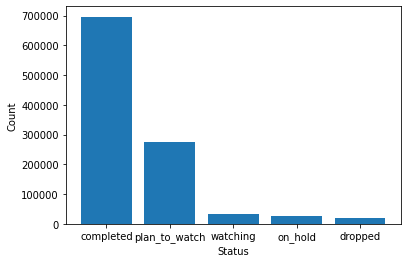

In [ ]:
# Count number of status
status = df_ratings_01['status'].unique()
n_status = df_ratings_01['status'].value_counts()
plt.bar(status, n_status)
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

## Data Pre-processing

In [ ]:
ratings_files = [os.path.join(DATA_PATH, 'user_anime', name) for name in os.listdir(DATA_PATH + '/user_anime')]
print("Total files: {0}\n".format(len(ratings_files)))

# Load all rating files
df_ratings = None
try:
    i = 1
    j = 1
    for path in ratings_files:
        with open(path, 'r') as f:
            rel = pd.read_csv(path)

            # select rows with score not NaN
            rel = rel[rel['score'].notna()]

            # join the data
            df_ratings = pd.concat([df_ratings, rel[['user_id', 'anime_id', 'score']]], ignore_index=True)
            print("{0} added | number row: {1}".format(path.split('/')[-1], str(len(df_ratings))))
            j += 1
            # if len(df_ratings) > 36000000: 
            #     print("{0} files added | number row: {1}".format(j, str(len(df_ratings))))
            #     break
    print("\nDownload Rating Files - completed\n")


except:
    print("The file is too lagre that the processing runtime cannot handel. Please reduce the data size.")

Total files: 70

user_anime00.csv added | number row: 618507
user_anime01.csv added | number row: 1217299
user_anime02.csv added | number row: 1827880
user_anime03.csv added | number row: 2432623
user_anime04.csv added | number row: 3039552
user_anime05.csv added | number row: 3658677
user_anime06.csv added | number row: 4253646
user_anime07.csv added | number row: 4862094
user_anime08.csv added | number row: 5471662
user_anime09.csv added | number row: 6063917
user_anime10.csv added | number row: 6651839
user_anime11.csv added | number row: 7246358
user_anime12.csv added | number row: 7846140
user_anime13.csv added | number row: 8448136
user_anime14.csv added | number row: 9068847
user_anime15.csv added | number row: 9717485
user_anime16.csv added | number row: 10323017
user_anime17.csv added | number row: 10916516
user_anime18.csv added | number row: 11532909
user_anime19.csv added | number row: 12144185
user_anime20.csv added | number row: 12772108
user_anime21.csv added | number ro

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


user_anime41.csv added | number row: 42519176

Download Rating Files - completed



In [ ]:
df_animes = df_animes[['anime_id', 'title', 'genres']]
df_users = df_users[['user_id']]

In [ ]:
df_users.head()

,user_id
0,kir1yama
1,smatster
2,suzuhrevv
3,pheseantnetsuke
4,skyuchiha


In [ ]:
df_animes.head()

,anime_id,title,genres
0,2366,Touma Kishinden Oni,Supernatural
1,4940,Sabaku no Kaizoku! Captain Kuppa,Action|Adventure
2,50285,On Air Dekinai!,Comedy
3,3975,Uchi no 3 Shimai,Comedy|Slice of Life
4,36036,Running Man,Action|Adventure|Kids


In [ ]:
df_ratings.head()

,user_id,anime_id,score
0,-------,1,8.0
1,-------,1003,8.0
2,-------,1004,7.0
3,-------,1015,8.0
4,-------,1023,8.0


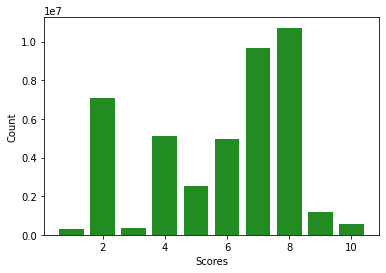

In [ ]:
scores = df_ratings['score'].unique()
n_scores = df_ratings['score'].value_counts()
plt.bar(scores, n_scores, color ='forestgreen')
plt.xlabel("Scores")
plt.ylabel("Count")
plt.show()

In [ ]:
anime_names = df_animes.set_index('anime_id')['title'].to_dict()
n_users = len(df_ratings.user_id.unique())
n_items = len(df_ratings.anime_id.unique())
print("===================================================================")
print(" Number of unique users:", n_users)
print(" Number of unique animes:", n_items)
print(" The full rating matrix will have:", n_users*n_items, 'elements.')
print(' ----------')
print(" Number of ratings:", len(df_ratings))
print(" Therefore: ", len(df_ratings) / (n_users*n_items) * 100, '% of the matrix is filled.')
print("===================================================================")

 Number of unique users: 321981
 Number of unique animes: 12963
 The full rating matrix will have: 4173839703 elements.
 ----------
 Number of ratings: 42519176
 Therefore:  1.018706491517602 % of the matrix is filled.


## Define the model (Matrix Factorization)

In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)
    
    def predict(self, user, item):
        return self.forward(user, item)

In [ ]:
# Creating the dataloader (necessary for PyTorch)
class Loader(Dataset):
    def __init__(self, data_set = None):

        self.ratings = data_set
        
        # Extract all user IDs and anime IDs
        users = df_ratings.user_id.unique()
        animes = df_ratings.anime_id.unique()
        
        # Unique values : index
        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.animeid2idx = {o:i for i,o in enumerate(animes)}
        
        # Obtained continuous ID for users and animes
        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2animeid = {i:o for o,i in self.animeid2idx.items()}
        
        self.ratings.anime_id = df_ratings.anime_id.apply(lambda x: self.animeid2idx[x])
        self.ratings.user_id = df_ratings.user_id.apply(lambda x: self.userid2idx[x])

        # x: user_id, anime_id, favorite, status
        # y: score
        self.x = self.ratings.drop(['score'], axis=1).values
        self.y = self.ratings['score'].values

        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms the data to tensors (ready for torch models.)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

## Train the model

In [ ]:
num_epochs = 16

model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# GPU enable if you have a GPU...
if torch.cuda.is_available():
    model = model.cuda()

# MSE loss
loss_fn = torch.nn.MSELoss()

# ADAM optimizier
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)

MatrixFactorization(
  (user_factors): Embedding(321981, 8)
  (item_factors): Embedding(12963, 8)
)
user_factors.weight tensor([[0.0285, 0.0191, 0.0145,  ..., 0.0465, 0.0056, 0.0106],
        [0.0026, 0.0074, 0.0311,  ..., 0.0028, 0.0250, 0.0441],
        [0.0052, 0.0139, 0.0446,  ..., 0.0403, 0.0309, 0.0013],
        ...,
        [0.0128, 0.0469, 0.0009,  ..., 0.0168, 0.0094, 0.0033],
        [0.0464, 0.0399, 0.0276,  ..., 0.0013, 0.0054, 0.0062],
        [0.0043, 0.0410, 0.0093,  ..., 0.0482, 0.0039, 0.0413]])
item_factors.weight tensor([[0.0175, 0.0412, 0.0319,  ..., 0.0118, 0.0461, 0.0103],
        [0.0171, 0.0373, 0.0192,  ..., 0.0479, 0.0290, 0.0122],
        [0.0376, 0.0251, 0.0442,  ..., 0.0180, 0.0091, 0.0468],
        ...,
        [0.0300, 0.0248, 0.0432,  ..., 0.0258, 0.0029, 0.0163],
        [0.0200, 0.0492, 0.0130,  ..., 0.0169, 0.0479, 0.0324],
        [0.0370, 0.0184, 0.0305,  ..., 0.0406, 0.0070, 0.0045]])


In [ ]:
# Split training and testing dataset
ratings_test = df_ratings.sample(frac = 0.2)

# Train data
train_set = Loader(data_set = df_ratings)
train_loader = DataLoader(train_set, 128, shuffle=True)
# Test data
test_set = Loader(data_set = ratings_test)
test_loader = DataLoader(test_set, 1, shuffle=False)

In [ ]:
Losses = []
for epoch in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
    if epoch+1 % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': sum(losses) / len(losses),
        }, os.path.join(CHECKPOINT_PATH, 'checkpoint{}.pt'.format(epoch)))
    
    print("epoch #{}".format(epoch), "Loss:", sum(losses) / len(losses))
    Losses.append(sum(losses))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/16 [00:00<?, ?it/s]

epoch #0 Loss: 3.615198501625993
epoch #1 Loss: 1.978408097007674
epoch #2 Loss: 1.7907836715525214
epoch #3 Loss: 1.7238471264927555
epoch #4 Loss: 1.6949904874301724
epoch #5 Loss: 1.6825207074771527
epoch #6 Loss: 1.6784709091879955
epoch #7 Loss: 1.6795741385018685
epoch #8 Loss: 1.6836386085347523
epoch #9 Loss: 1.6892648204524014
epoch #10 Loss: 1.6960755223990884
epoch #11 Loss: 1.7033151618722695
epoch #12 Loss: 1.7108726491325046
epoch #13 Loss: 1.718602338063399
epoch #14 Loss: 1.7262751882668652
epoch #15 Loss: 1.7329404184765673


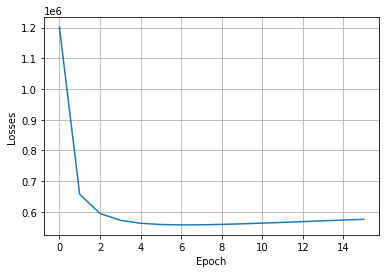

In [ ]:
plt.plot(np.arange(len(Losses)), Losses)
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.grid(True)
plt.show()

In [ ]:
# By training the model, we will have tuned latent factors for animes and users.
c = 0
uw = 0
iw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data

user_factors.weight tensor([[ 1.8372,  4.4100,  5.6149,  ...,  1.3234,  7.5577,  1.7954],
        [ 3.4629,  2.8392,  4.5223,  ...,  4.3875,  4.9851,  2.8147],
        [ 1.8819,  0.7839,  2.7613,  ...,  3.3644,  5.0206, 10.0611],
        ...,
        [ 6.3777,  0.1180,  7.7428,  ...,  6.2913,  5.7031,  5.1705],
        [ 6.0512,  4.4688,  2.4030,  ...,  6.1466,  4.2288,  4.9816],
        [ 4.6728,  5.1591,  3.4861,  ...,  4.0622,  3.8232,  3.8887]],
       device='cuda:0')
item_factors.weight tensor([[ 0.2354,  0.2195,  0.3122,  ..., -0.3024,  0.2529,  0.2358],
        [ 0.2668,  0.0637,  0.3887,  ...,  0.2451,  0.0485,  0.1303],
        [ 0.3255, -0.1275,  0.4259,  ..., -0.1014,  0.3180,  0.1810],
        ...,
        [ 0.0298,  0.0248,  0.0432,  ...,  0.0258,  0.0029, -0.1420],
        [-0.0083,  0.0424,  0.0091,  ...,  0.0085,  0.0446,  0.0263],
        [ 0.1958,  0.1773,  0.1893,  ...,  0.1994,  0.1658,  0.1633]],
       device='cuda:0')


In [ ]:
torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'model_d.pt'))

## Test the model

In [ ]:
trained_anime_embeddings = model.item_factors.weight.data.cpu().numpy()

len(trained_anime_embeddings)

12963

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_anime_embeddings)

In [ ]:
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)

In [ ]:
for cluster in range(10):
    print(colored(255, 0, 0, "Cluster #{}".format(cluster)))
    animations = []

    for animeidx in np.where(kmeans.labels_ == cluster)[0]:
        animeid = train_set.idx2animeid[animeidx]
        rat_count = df_ratings.loc[df_ratings['anime_id']==animeid].count()[0]
        animations.append((anime_names[animeid], rat_count))

    for animation in sorted(animations, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", animation[0])

Cluster #0 
	 Slayers
	 Iketeru Futari
	 Paniponi Dash!
	 Onegai‚òÜTwins: Natsu wa Owaranai
	 Ueki no Housoku
	 Mahoromatic Summer Special
	 Tenchi Muyou! Ryououki 2nd Season
	 Major S1
	 Takahashi Rumiko Gekijou Ningyo no Mori
	 Ichigo Mashimaro
Cluster #1 
	 Green Green Thirteen: Erolutions
	 Canvas: Sepia-iro no Motif
	 Sexfriend
	 Tokyo Daigaku Monogatari
	 Ai Shimai: Futari no Kajitsu
	 Chijoku Shinsatsushitsu
	 Dousou Kai Again
	 Usagi-chan de Cue!!
	 Ningen Kousaten
	 Honoo no Labyrinth
Cluster #2 
	 Kenritsu Chikyuu Boueigun
	 Hatara Kids Mai Ham Gumi
	 Mirai Keisatsu Urashiman
	 Shin-ban Megami Tantei Vinus File
	 Makasete Iruka!
	 Asgaldh: The Distortion Testament
	 Gegege no Kitarou (2007)
	 Mister Ajikko
	 Ore wa Teppei
	 Miboujin: Numeriau Nikuyoku to Midara ni Nureru Mitsusubo
Cluster #3 
	 PopoloCrois
	 Colorful
	 Gall Force: New Era
	 Kijoku: Princess Double Kari
	 Monkey Turn V
	 Tokubetsu Jugyou 2
	 Unbalance
	 Generation of Chaos Next: Chikai no Pendant
	 Virus: Viru

## Evaluate the model

In [ ]:
rec = MatrixFactorization(n_users = n_users, n_items = n_items, n_factors=8)
rec.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'model_r16.pt')))
rec.eval()
rec = rec.cuda()

In [ ]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [ ]:
y_predicted = []
y_actual = []

for x, y in test_loader:
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
        output = rec(x)

        y_predicted.append(output.tolist())
        y_actual.append(y.tolist())


RMSE, MAE = error_metrics(y_actual, y_predicted)

In [ ]:
print("RMSE = {}\nMAE = {}".format(RMSE, MAE))

RMSE = 1.3024180263183143
MAE = 0.9699422212183143
